In [1]:
import numpy as np
import pandas as pd
import glob as glob 
import os
import pathlib
import matplotlib.pyplot as plt

from radar import RadarMesure

import re


# Fichiers bruts
file_list = glob.glob('../data/fm_on_snowpacks/J5/*')

# Dictionnaires séparés par fréquence
classic_dict_13 = {}
classic_dict_17 = {}

# Remplissage des dictionnaires
for file in file_list:
    # On ignore les fichiers d'excavation
    if "excav" in os.path.split(file)[1]:
        continue

    match = re.search(r'v_(\d+)deg', file)
    if not match:
        continue

    angle = int(match.group(1))

    rm = RadarMesure(file)
    freq = rm.frequence   # tu as confirmé frequence

    if freq == 13:
        classic_dict_13[angle] = file
    elif freq == 17:
        classic_dict_17[angle] = file

common_angles = sorted(set(classic_dict_13.keys()) & set(classic_dict_17.keys()))
data_13 = [RadarMesure(classic_dict_13[a]) for a in common_angles]
data_17 = [RadarMesure(classic_dict_17[a]) for a in common_angles]


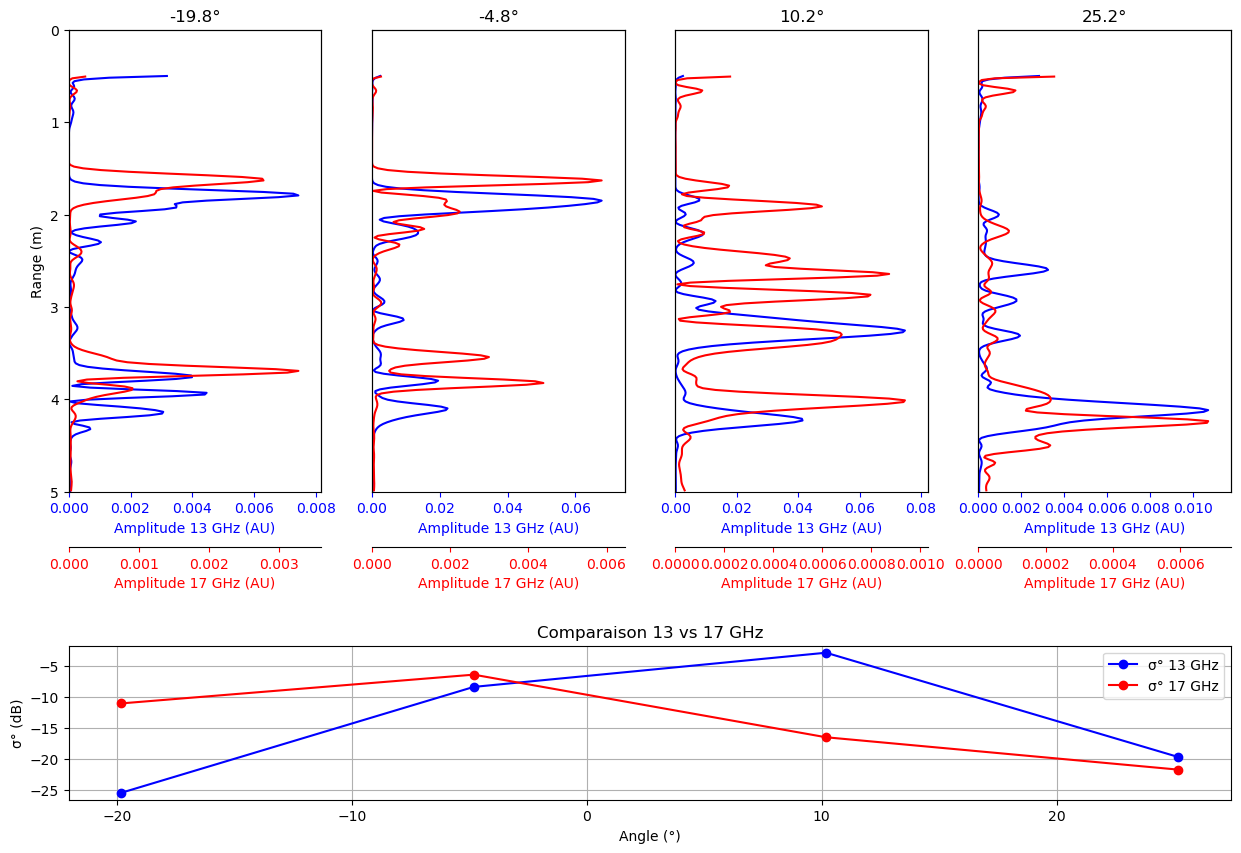

In [6]:

def plot_dual_frequency(data13, data17, title_prefix="Comparaison fréquences"):
    angles = [d.angle_local for d in data13] 
    pente = data13[0].pente

    fig = plt.figure(figsize=(15, 10))
    gs = fig.add_gridspec(2, len(angles), height_ratios=[3, 1], hspace=0.5)

    sigma13 = []
    sigma17 = []

    for i, (f13, f17, angle) in enumerate(zip(data13, data17, angles)):

        df13 = f13.df.loc[0.5:5]
        df17 = f17.df.loc[0.5:5]

        sigma13.append(f13.sigma0)
        sigma17.append(f17.sigma0)

        # === Axe principal (13 GHz) ===
        ax = fig.add_subplot(gs[0, i])
        ax.plot(df13["copol"], df13.index, color="blue", label="13 GHz")
        ax.set_xlim(0, df13["copol"].max() * 1.1)
        ax.set_ylim(5, 0)
        ax.set_xlabel("Amplitude 13 GHz (AU)", color="blue")
        ax.tick_params(axis='x', colors='blue')

        # === Axe secondaire (17 GHz) sous le principal ===
        ax2 = ax.twiny()  # on crée un axe secondaire
        ax2.plot(df17["copol"], df17.index, color="red", linestyle="-", label="17 GHz")
        ax2.set_xlim(0, df17["copol"].max() * 1.1)

        # Décaler l'axe secondaire vers le bas
        ax2.spines['bottom'].set_position(('outward', 40))  # 40 pixels sous le bas
        ax2.xaxis.set_ticks_position('bottom')
        ax2.xaxis.set_label_position('bottom')
        ax2.set_xlabel("Amplitude 17 GHz (AU)", color="red")
        ax2.tick_params(axis='x', colors='red')

        ax.set_title(f"{angle - pente:.1f}°")

        if i == 0:
            ax.set_ylabel("Range (m)")
        else:
            ax.set_yticks([])

    # === Bas : sigma0 ===
    ax_bottom = fig.add_subplot(gs[1, :])
    ax_bottom.plot([a - pente for a in angles], sigma13,
                   marker='o', color='blue', label="σ° 13 GHz")
    ax_bottom.plot([a - pente for a in angles], sigma17,
                   marker='o', color='red', linestyle='-', label="σ° 17 GHz")

    ax_bottom.set_xlabel("Angle (°)")
    ax_bottom.set_ylabel("σ° (dB)")
    ax_bottom.set_title(title_prefix)
    ax_bottom.grid(True)
    ax_bottom.legend()

    plt.show()


plot_dual_frequency(data_13, data_17, title_prefix="Comparaison 13 vs 17 GHz")

